# CITRA DATA

#### Path Citra

In [418]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mediapipe as mp
import random
from skimage.feature import local_binary_pattern
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV


# Path citra
dataset_path = r"D:\Belajar Machine Learning\famscreen_ml\data_mentah"

# FUNGSI PROGRAM

#### Fungsi Konversi Ketegori Umur

In [419]:
# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
       if 1 <= age <= 12:
              return 0  # 1+
       elif 13 <= age <= 16:
              return 1  # 13+
       elif 17 <= age <= 110:
              return 2 # 17+
       return -1  # Label tidak valid

#### Fungsi Enhancement Citra

In [420]:
# Fungsi untuk melakukan enhancement pada citra
def enhance_image(image):
       """
       Fungsi untuk meningkatkan kualitas citra menggunakan teknik sharpening.

       Parameter:
       image : numpy array
              Citra input, bisa berupa citra berwarna (BGR) atau grayscale.

       Return:
       enhanced_img : numpy array
              Citra hasil setelah dilakukan enhancement (sharpening).
       """

       # Periksa apakah citra memiliki 3 kanal (citra berwarna)
       if len(image.shape) == 3:  
              # Jika berwarna (BGR), ubah menjadi grayscale
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       else:
              # Jika sudah grayscale, gunakan langsung
              gray = image  

       # Definisikan kernel sharpening (ukuran 3x3)
       # Nilai positif di tengah meningkatkan kontras, nilai negatif di sekitar meredam noise
       kernel = np.array([
              [0, -0.5, 0],
              [-0.5, 3, -0.5],
              [0, -0.5, 0]
       ])

       # Aplikasikan filter kernel pada citra grayscale untuk melakukan sharpening
       enhanced_img = cv2.filter2D(gray, -1, kernel)

       # Kembalikan citra yang telah ditingkatkan
       return enhanced_img


#### Fungsi Deteksi Wajah

In [421]:
# Inisialisasi Mediapipe Face Mesh untuk deteksi wajah
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
       static_image_mode=True,               # Mode gambar statis (tidak video streaming)
       max_num_faces=1,                      # Maksimal mendeteksi 1 wajah
       refine_landmarks=True,                # Menggunakan landmark yang lebih presisi
       min_detection_confidence=0.5          # Kepercayaan minimum deteksi wajah
)

def detect_face_mediapipe(img):
       """
       Fungsi untuk mendeteksi wajah pada citra menggunakan Mediapipe Face Mesh.

       Parameter:
       img : numpy array
              Citra input dengan format BGR.

       Return:
       cropped_face : numpy array
              Citra hasil crop berdasarkan bounding box wajah.
              Return None jika tidak ada wajah terdeteksi.
       """
       
       # Konversi citra dari BGR ke RGB, karena Mediapipe hanya mendukung format RGB
       rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

       # Proses deteksi wajah menggunakan Mediapipe
       results = face_mesh.process(rgb_img)

       # Jika tidak ada wajah yang terdeteksi, kembalikan None
       if not results.multi_face_landmarks:
              return None

       # Ambil landmark dari wajah pertama yang terdeteksi
       face_landmarks = results.multi_face_landmarks[0]

       # Hitung koordinat landmark dalam piksel (dikonversi dari relatif ke ukuran asli gambar)
       h, w = img.shape[:2]  # Ambil dimensi tinggi (h) dan lebar (w) dari gambar
       landmarks_points = [
              (int(landmark.x * w), int(landmark.y * h))  # Ubah koordinat relatif ke piksel
              for landmark in face_landmarks.landmark
       ]

       # Hitung bounding box wajah berdasarkan koordinat landmark
       x_min = min([point[0] for point in landmarks_points])  # Koordinat X minimum
       y_min = min([point[1] for point in landmarks_points])  # Koordinat Y minimum
       x_max = max([point[0] for point in landmarks_points])  # Koordinat X maksimum
       y_max = max([point[1] for point in landmarks_points])  # Koordinat Y maksimum

       # Potong (crop) gambar berdasarkan bounding box wajah
       cropped_face = img[y_min:y_max, x_min:x_max]

       return cropped_face

#### Fungsi Visualisasi LBP untuk Menentukan Nilai R & P

In [422]:
# Fungsi untuk visualisasi LBP (Local Binary Pattern) dengan berbagai parameter
def visualize_lbp(image, radii, n_points_list):
       """
       Fungsi untuk memvisualisasikan hasil ekstraksi fitur LBP pada citra
       menggunakan berbagai kombinasi parameter radius dan jumlah titik.

       Parameter:
       image : numpy array
              Citra input, sebaiknya sudah dalam format grayscale.
       radii : list
              Daftar nilai radius yang digunakan untuk LBP.
       n_points_list : list
              Daftar jumlah titik (P) yang digunakan untuk LBP.
       """
       # Membuat grid untuk menampilkan hasil (subplots)
       fig, axes = plt.subplots(len(radii), len(n_points_list), figsize=(30, 30))

       # Iterasi untuk setiap kombinasi radius dan jumlah titik
       for i, radius in enumerate(radii):
              for j, n_points in enumerate(n_points_list):
              
                     # Tingkatkan kualitas citra menggunakan fungsi enhance_image
                     enhanced_img = enhance_image(image)
                     
                     # Deteksi wajah menggunakan Mediapipe dan crop wajah dari citra
                     cropped_face = detect_face_mediapipe(enhanced_img)

                     # Jika tidak ada wajah terdeteksi, lewati iterasi ini
                     if cropped_face is None:
                            print(f"Tidak ada wajah terdeteksi untuk radius={radius} dan n_points={n_points}")
                            continue

                     # Ekstraksi fitur LBP
                     lbp_image = local_binary_pattern(cropped_face, n_points, radius, method='uniform')

                     # Tampilkan hasil LBP pada subplot
                     ax = axes[i, j]
                     ax.imshow(lbp_image, cmap='gray')  # Tampilkan citra LBP dengan warna grayscale
                     ax.set_title(f"R={radius}, P={n_points}", fontsize=20)  # Judul berdasarkan radius dan P
                     ax.axis('off')  # Hilangkan sumbu pada subplot

       # Atur jarak antar subplot untuk tampilan lebih rapi
       plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
       plt.show()

# Contoh penggunaan

# Path ke citra input 
image_path = r"D:\Belajar Machine Learning\famscreen_ml\data\11_dasd.jpg"

# Membaca citra dalam format grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Variasi parameter radius (R) dan jumlah titik (P) untuk LBP
radii = [1, 2, 3, 4, 5, 6, 7, 8]  # Radius LBP
n_points_list = [8, 16, 24]        # Jumlah titik LBP

# Visualisasi fitur LBP dengan berbagai kombinasi parameter
visualize_lbp(image, radii, n_points_list)

#### Fungsi Ekstraksi Menggunakan LBP

In [423]:
# Fungsi untuk ekstraksi fitur LBP (Local Binary Pattern)
def extract_lbp_features(image, radius=3, n_points=24):
       """
       Fungsi untuk mengekstraksi fitur LBP dari citra dan menghasilkan histogram yang ter-normalisasi.

       Parameter:
       image : numpy array
              Citra input dalam format grayscale.
       radius : int
              Radius untuk menghitung LBP (default = 3).
       n_points : int
              Jumlah titik yang digunakan untuk LBP (default = 24).

       Return:
       lbp_hist : numpy array
              Histogram ter-normalisasi dari nilai LBP.
       """

       # Validasi input: Periksa apakah citra valid
       if image is None or image.size == 0:
              raise ValueError("Gambar yang diteruskan kosong atau tidak valid")

       # Hitung LBP pada citra
       # Parameter `method='uniform'` digunakan untuk menghasilkan pola LBP yang lebih kompak
       lbp = local_binary_pattern(image, n_points, radius, method="uniform")

       # Hitung histogram dari nilai-nilai LBP
       # Bins mencakup semua pola unik yang mungkin, ditambah dua pola tambahan untuk metode "uniform"
       lbp_hist, _ = np.histogram(
              lbp.ravel(),                # Flatten citra LBP menjadi satu dimensi
              bins=np.arange(0, n_points + 3),  # Bin dari 0 hingga (n_points + 2)
              range=(0, n_points + 2)    # Rentang nilai LBP
       )

       # Normalisasi histogram agar total probabilitas = 1
       # Normalisasi penting untuk membuat fitur tidak bergantung pada ukuran citra
       lbp_hist = lbp_hist.astype("float")
       lbp_hist /= (lbp_hist.sum() + 1e-6)  # Hindari pembagian dengan nol

       return lbp_hist

# DATA PREPROCESSING & EKSTRAKSI FITUR

#### Preprocessing Data & Ekstraksi Fitur

In [424]:
# Inisialisasi list untuk menyimpan data hasil ekstraksi fitur
data = []

# Mendapatkan daftar file gambar dalam folder dataset
# Hanya file dengan ekstensi .jpg atau .JPG yang diambil
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".JPG"))]

# Dictionary untuk mengelompokkan gambar berdasarkan kategori umur
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
       # Split nama file untuk mengambil informasi umur (age)
       parts = image_file.split('_')
       age = int(parts[0])  # Informasi usia berada di indeks pertama nama file

       # Kategorikan umur menggunakan fungsi `categorize_age`
       age_category = categorize_age(age)

       # Jika kategori umur valid (0, 1, 2, 3), tambahkan ke kelompok kategori
       if age_category in [0, 1, 2]:
              if age_category not in image_data_by_age:
                     image_data_by_age[age_category] = []
              image_data_by_age[age_category].append(image_file)

# List untuk menyimpan gambar yang telah diproses
processed_images = []

# Proses setiap kategori umur dan file gambar di dalamnya
for age_category, files in image_data_by_age.items():
       for image_file in files:
              # Dapatkan path lengkap untuk file gambar
              image_path = os.path.join(dataset_path, image_file)

              # Baca gambar dari path dan konversi ke grayscale
              image = cv2.imread(image_path)

              # Lakukan enhancement pada gambar untuk meningkatkan kualitas
              enhanced_img = enhance_image(image)

              # Deteksi wajah dan crop menggunakan Mediapipe
              cropped_face = detect_face_mediapipe(enhanced_img)

              # Pastikan cropped face valid (tidak None atau kosong)
              if cropped_face is not None and cropped_face.size > 0:
                     # Simpan gambar wajah yang telah diproses
                     processed_images.append(cropped_face)

                     # Ekstraksi fitur LBP dari gambar cropped face
                     lbp_features_cropped = extract_lbp_features(cropped_face)

                     # Tambahkan kategori umur dan fitur LBP ke dalam list data
                     # Konversi fitur LBP ke list agar dapat digabungkan dengan kategori umur
                     data.append([age_category] + lbp_features_cropped.tolist())


#### Visualisasi dan Ekstraksi Fitur Citra Wajah

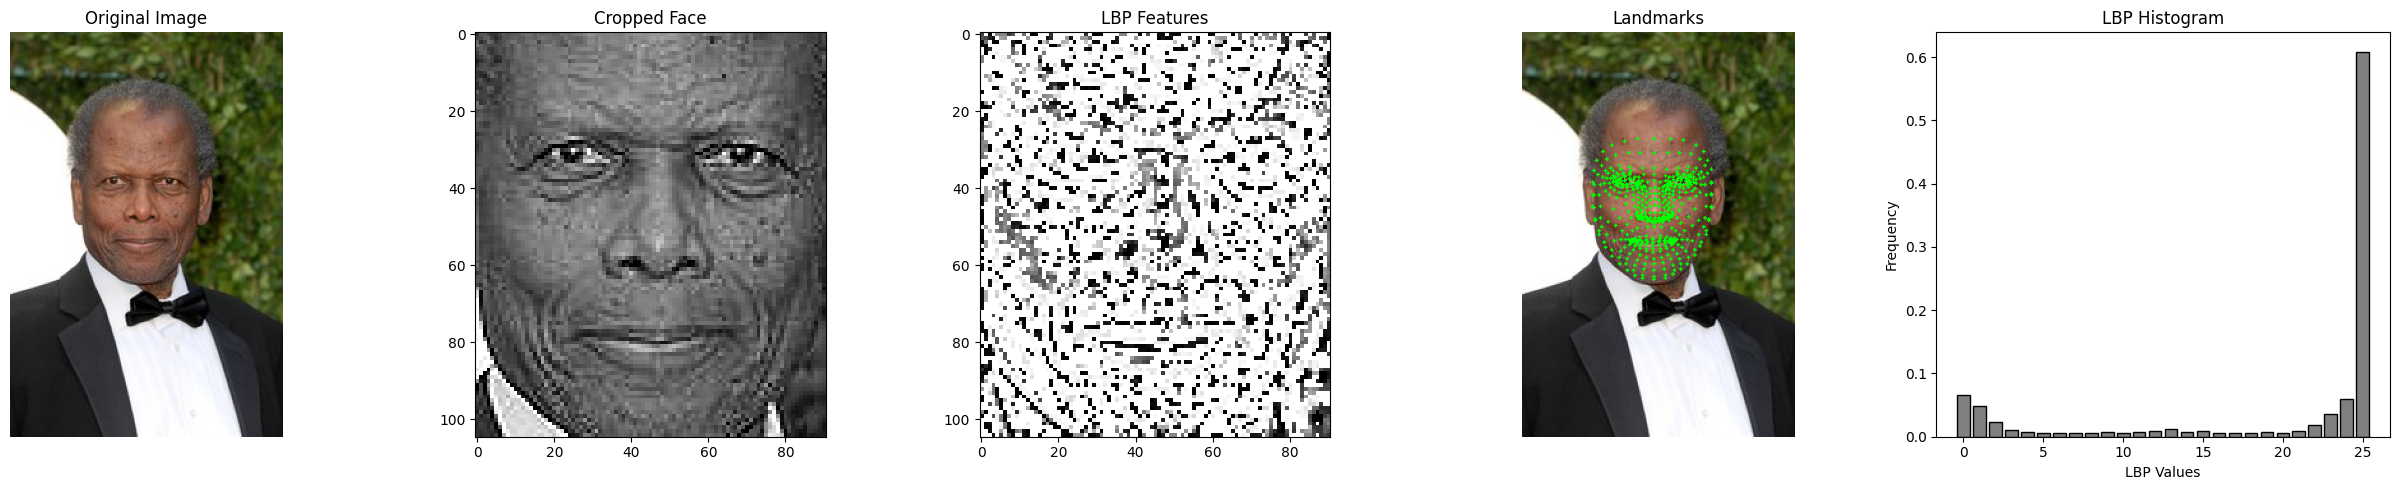

In [425]:
# Pastikan processed_images tidak kosong sebelum memproses
if len(processed_images) > 0:
       # Ambil maksimum 1 elemen secara acak dari list gambar
       num_samples = min(1, len(processed_images))
       random_files = random.sample(image_files, num_samples)

       for i, image_file in enumerate(random_files):
              # Dapatkan path lengkap dari file gambar
              image_path = os.path.join(dataset_path, image_file)
              image = cv2.imread(image_path)  # Baca gambar

              # Konversi gambar ke RGB untuk ditampilkan dengan benar di matplotlib
              original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

              # Lakukan peningkatan kualitas gambar
              enhanced_img = enhance_image(image)

              # Deteksi wajah dan crop menggunakan fungsi mediapipe
              cropped_face = detect_face_mediapipe(enhanced_img)

              # Konversi gambar ke RGB untuk deteksi titik landmark wajah
              rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              results = face_mesh.process(rgb_img)  # Proses deteksi landmark wajah

              # Salin gambar RGB untuk menggambar titik landmark
              landmark_image = rgb_img.copy()
              if results.multi_face_landmarks:  # Jika ada landmark wajah yang terdeteksi
                     for face_landmarks in results.multi_face_landmarks:
                            for landmark in face_landmarks.landmark:
                                   h, w = rgb_img.shape[:2]  # Ambil tinggi dan lebar gambar
                                   # Hitung koordinat x dan y dari landmark
                                   x = int(landmark.x * w)
                                   y = int(landmark.y * h)
                                   # Gambar titik pada koordinat landmark
                                   cv2.circle(landmark_image, (x, y), 1, (0, 255, 0), -1)

              # Ekstraksi fitur LBP pada wajah yang sudah di-crop
              if cropped_face is not None and cropped_face.size > 0:
                     # LBP diterapkan dengan 24 poin dan radius 3
                     lbp_image = local_binary_pattern(cropped_face, 24, 3, method="uniform")

                     # Hitung histogram LBP untuk menggambarkan distribusi pola tekstur
                     hist, bins = np.histogram(lbp_image.ravel(), bins=np.arange(0, 27), range=(0, 26))
                     hist = hist.astype("float")  # Konversi ke float untuk normalisasi
                     hist /= hist.sum()  # Normalisasi histogram

                     # Visualisasi hasil dalam satu baris dengan 5 kolom
                     fig, axes = plt.subplots(1, 5, figsize=(25, 5))

                     # Kolom 1: Tampilkan gambar asli
                     axes[0].imshow(original_image)
                     axes[0].set_title("Original Image")
                     axes[0].axis('off')  # Hilangkan sumbu

              # Kolom 2: Tampilkan wajah yang sudah di-crop
              if cropped_face is not None:
                     axes[1].imshow(cropped_face, cmap='gray')
                     axes[1].set_title("Cropped Face")
              else:
                     # Jika tidak ada wajah yang terdeteksi, tampilkan teks
                     axes[1].text(0.5, 0.5, "No face detected", ha='center', va='center', transform=axes[1].transAxes)
                     axes[1].axis('off')

              # Kolom 3: Tampilkan hasil LBP
              if cropped_face is not None:
                     axes[2].imshow(lbp_image, cmap='gray')
                     axes[2].set_title("LBP Features")
              else:
                     axes[2].text(0.5, 0.5, "No face detected", ha='center', va='center', transform=axes[2].transAxes)
                     axes[2].axis('off')

              # Kolom 4: Tampilkan gambar dengan titik landmark
              axes[3].imshow(landmark_image)
              axes[3].set_title("Landmarks")
              axes[3].axis('off')

              # Kolom 5: Tampilkan histogram LBP
              if cropped_face is not None:
                     axes[4].bar(bins[:-1], hist, width=0.8, color='gray', edgecolor='black')
                     axes[4].set_title("LBP Histogram")
                     axes[4].set_xlabel("LBP Values")
                     axes[4].set_ylabel("Frequency")
              else:
                     # Jika tidak ada wajah yang terdeteksi, tampilkan teks
                     axes[4].text(0.5, 0.5, "No face detected", ha='center', va='center', transform=axes[4].transAxes)
                     axes[4].axis('on')  # Tampilkan sumbu untuk histogram

              plt.tight_layout()  # Sesuaikan tata letak plot
              plt.show()
else:
    # Jika processed_images kosong, tampilkan pesan ke pengguna
    print("processed_images kosong, tidak ada gambar yang bisa ditampilkan.")

# SIMPAN FITUR KE DATA FRAME

#### Penyimpanan Fitur ke DataFrame dan Ekspor ke File CSV

In [426]:
# Hitung jumlah fitur LBP dari gambar yang sudah di-crop
num_lbp_features = len(lbp_features_cropped)

# Update nama kolom secara dinamis berdasarkan jumlah fitur LBP yang ada
# Kolom pertama adalah 'age_category', sisanya adalah 'pixel_0', 'pixel_1', dst.
columns = ['age_category'] + [f'pixel_{i}' for i in range(num_lbp_features)]

# Konversi data menjadi DataFrame dengan kolom yang telah diperbarui
df = pd.DataFrame(data, columns=columns)

# Simpan DataFrame ke dalam file CSV tanpa indeks
df.to_csv("df_fitur.csv", index=False)

# DATA CLEANING

#### Cek Informasi Data

In [427]:
# Membaca data dari CSV
df = pd.read_csv("df_fitur.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             2  0.069494  0.045488  0.021376  0.010667  0.007037  0.005089   
1             2  0.056201  0.026621  0.021760  0.017662  0.014811  0.013092   
2             2  0.031523  0.020515  0.016253  0.012729  0.012866  0.012456   
3             2  0.040475  0.022970  0.017219  0.014551  0.013534  0.013471   
4             2  0.055898  0.034563  0.022486  0.012500  0.010150  0.007660   

    pixel_6   pixel_7   pixel_8  ...  pixel_16  pixel_17  pixel_18  pixel_19  \
0  0.004844  0.005089  0.005536  ...  0.006270  0.005759  0.005695  0.006292   
1  0.011410  0.012469  0.014001  ...  0.015974  0.015907  0.014811  0.016665   
2  0.011172  0.015051  0.018985  ...  0.020842  0.017728  0.014259  0.014232   
3  0.012899  0.016012  0.019189  ...  0.019253  0.015758  0.013534  0.014455   
4  0.007049  0.007707  0.009727  ...  0.011513  0.010644  0.009610  0.009868   

   pixel_20  pixel_21  pixel_22  pixel_23  p

#### Cek Data Duplikat

In [428]:
# Mengecek jumlah duplikasi
duplicates = df.duplicated()
print("\nJumlah data duplikat:", duplicates.sum())

# Menghapus duplikasi (jika ada)
df = df.drop_duplicates()
print("\nJumlah data setelah duplikasi dihapus:", df.shape[0])


Jumlah data duplikat: 2

Jumlah data setelah duplikasi dihapus: 615


# EDA - Distribusi Data

#### Distribusi Data

age_category
2    342
0    179
1     94
Name: count, dtype: int64


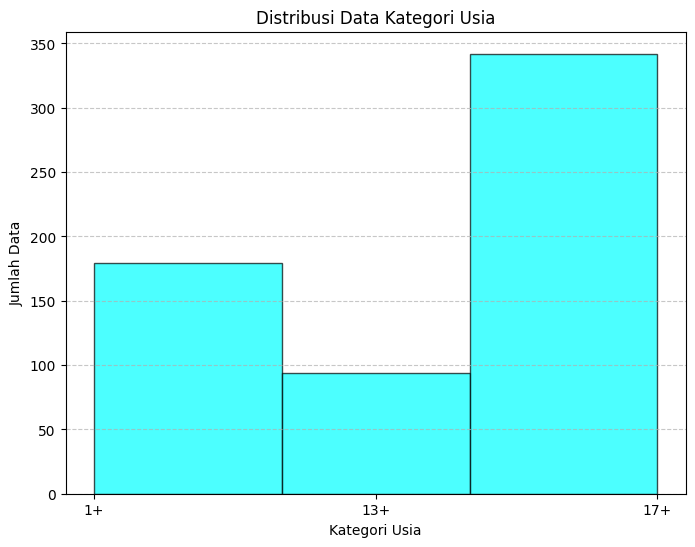

In [429]:
# Memeriksa distribusi kategori usia
age_distribution = df['age_category']
print(age_distribution.value_counts())

# Membuat histogram dengan warna hijau cyan
plt.figure(figsize=(8, 6))
plt.hist(age_distribution, bins=3, edgecolor='black', alpha=0.7, color='cyan')
plt.title("Distribusi Data Kategori Usia")
plt.xlabel("Kategori Usia")
plt.ylabel("Jumlah Data")
plt.xticks(ticks=[0, 1, 2], labels=["1+", "13+", "17+"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# DATA SPLITTING

#### Split Data & Menyeimbangkan Data

In [430]:
# Memisahkan fitur dan target
X = df.drop(columns=['age_category'])       # Fitur
y = df['age_category']                      # Target

# Menyeimbangkan kategori dengan SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#### Visualisasi Distribusi Data Setelah di Seimbangkan

Distribusi kategori usia setelah SMOTE:
age_category
2    342
0    342
1    342
Name: count, dtype: int64


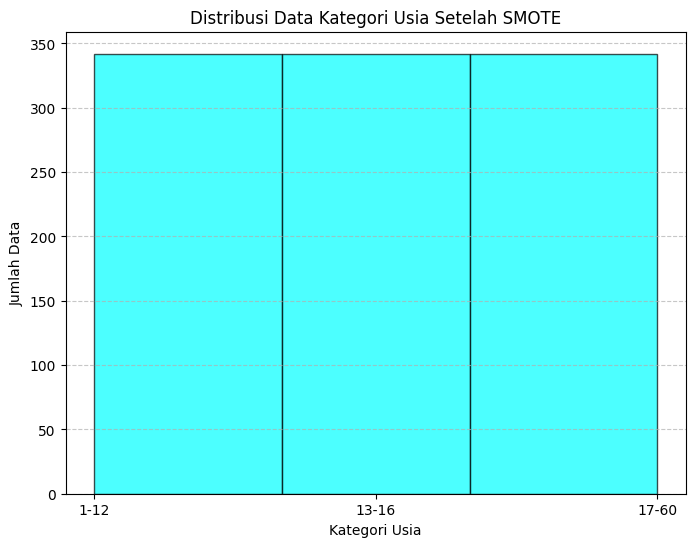

In [431]:
# Memeriksa distribusi kategori usia setelah SMOTE
age_distribution_resampled = y_resampled
print("Distribusi kategori usia setelah SMOTE:")
print(age_distribution_resampled.value_counts())

# Membuat histogram distribusi kategori usia setelah SMOTE
plt.figure(figsize=(8, 6))
plt.hist(age_distribution_resampled, bins=3, edgecolor='black', alpha=0.7, color='cyan')
plt.title("Distribusi Data Kategori Usia Setelah SMOTE")
plt.xlabel("Kategori Usia")
plt.ylabel("Jumlah Data")
plt.xticks(ticks=[0, 1, 2], labels=["1-12", "13-16", "17-60"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# MODELLING

#### Pemodelan dan Evaluasi Model SVM RBF dengan Grid Search

In [432]:
# Grid Search untuk SVM dengan kernel RBF
param_grid_rbf = {'C': [1e-3, 1, 1e3, 1e5], 'gamma': [1e-3, 1, 1e3]}  # Parameter grid
svm_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)  # Inisialisasi GridSearchCV dengan 5-fold cross-validation
svm_rbf.fit(X_train, y_train)  # Melatih model dengan data training

# Menyimpan model terbaik yang ditemukan oleh Grid Search
best_rbf_model = svm_rbf.best_estimator_

# Menampilkan parameter terbaik dari Grid Search
best_params = svm_rbf.best_params_
print("Parameter Terbaik dari Grid Search:")
print(best_params)

# Evaluasi model terbaik pada data test
y_pred_rbf = best_rbf_model.predict(X_test)  # Memprediksi data test

# Menampilkan hasil evaluasi pada data test
print("Akurasi Model SVM RBF (Test Data):", accuracy_score(y_test, y_pred_rbf) * 100, "%")
print("\nClassification Report (RBF SVM - Test Data):\n", classification_report(y_test, y_pred_rbf))

# Menampilkan akurasi validasi silang rata-rata dari grid search
mean_validation_accuracy = svm_rbf.best_score_
print("Akurasi Validasi Rata-rata (Cross-Validation):", mean_validation_accuracy * 100, "%")

Parameter Terbaik dari Grid Search:
{'C': 1000.0, 'gamma': 1000.0}
Akurasi Model SVM RBF (Test Data): 83.00970873786407 %

Classification Report (RBF SVM - Test Data):
               precision    recall  f1-score   support

           0       0.82      0.83      0.83        66
           1       0.83      0.94      0.88        69
           2       0.84      0.72      0.77        71

    accuracy                           0.83       206
   macro avg       0.83      0.83      0.83       206
weighted avg       0.83      0.83      0.83       206

Akurasi Validasi Rata-rata (Cross-Validation): 79.51219512195122 %


# EVALUASI MODEL

#### Visualisasi Model Menggunakan Confusion Matrix

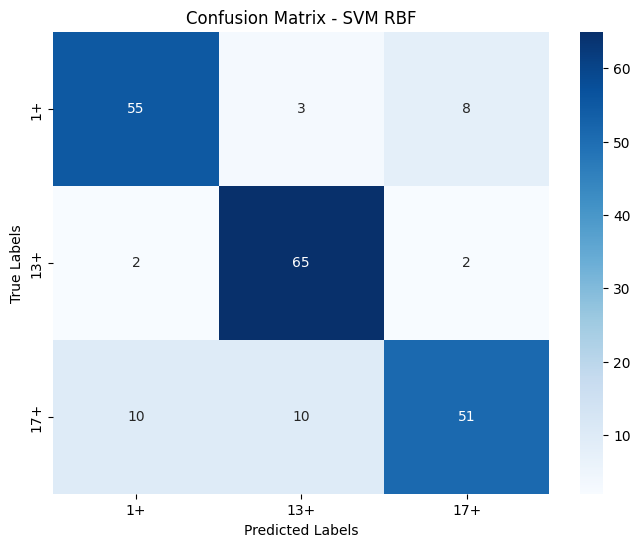

In [433]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)

# Menentukan label yang sesuai untuk kategori usia
age_labels = ['1+', '13+', '17+']

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=age_labels, yticklabels=age_labels)
plt.title('Confusion Matrix - SVM RBF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# SIMPAN MODEL

In [434]:
# Menyimpan model menggunakan joblib
joblib.dump(best_rbf_model, "famscreen_model.pkl")

['famscreen_model.pkl']

# PENGUJIAN MODEL

#### Load Model

In [435]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_model.pkl')

#### Uji Model Menggunakan Inputan Gambar

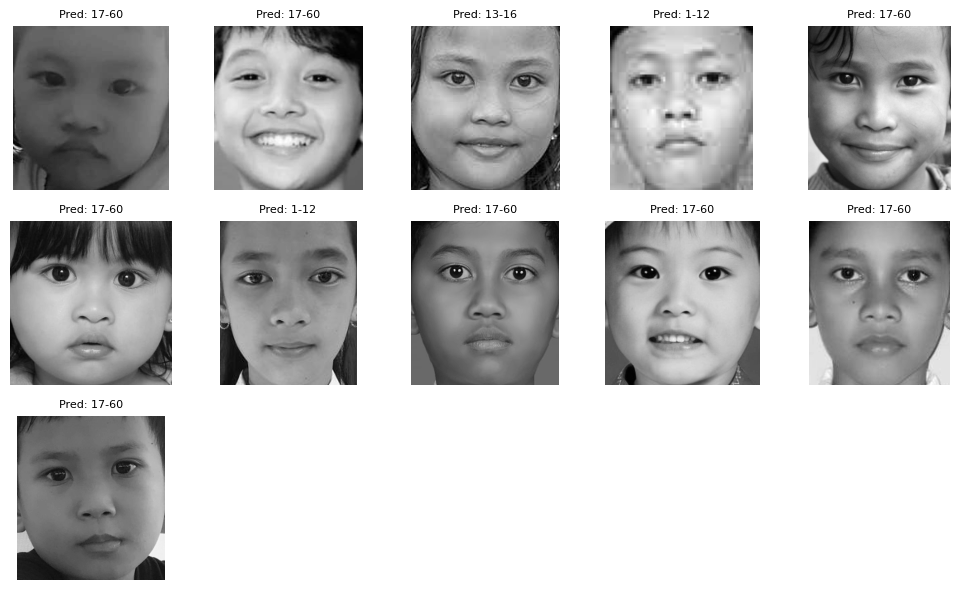

In [436]:
# Fungsi untuk memproses gambar dan memprediksi kategori usia
def predict_age_category(image_path, model):
    # Membaca gambar dari path
    image = cv2.imread(image_path)
    
    if image is None:  # Cek apakah gambar valid
        raise ValueError(f"Gambar tidak dapat dibaca atau kosong: {image_path}")
    
    # Mengubah gambar menjadi grayscale
    enhanced_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Deteksi wajah dan potong bagian wajah
    cropped_face = detect_face_mediapipe(enhanced_img)
    
    if cropped_face is None:  # Jika tidak ada wajah yang terdeteksi
        print(f"Tidak ada wajah yang terdeteksi pada gambar: {image_path}")
        return None, image, None
    
    if cropped_face.size == 0:  # Cek apakah wajah yang terpotong kosong
        print(f"Wajah yang terpotong kosong: {image_path}")
        return None, image, None
    
    # Ekstraksi fitur LBP dari wajah yang terdeteksi
    try:
        lbp_features = extract_lbp_features(cropped_face)
    except ValueError as e:  # Menangani error jika ekstraksi gagal
        print(f"Error saat ekstraksi LBP pada gambar {image_path}: {e}")
        return None, image, cropped_face
    
    # Mengubah fitur menjadi format 2D untuk prediksi
    lbp_features = np.array(lbp_features).reshape(1, -1)
    feature_names = df.columns[1:]  # Mengambil kolom fitur kecuali 'age_category'
    
    # Membuat DataFrame untuk prediksi
    lbp_features_df = pd.DataFrame(lbp_features, columns=feature_names)
    
    # Prediksi kategori usia menggunakan model
    age_category_pred = model.predict(lbp_features_df)
    
    return age_category_pred[0], image, cropped_face  # Mengembalikan kategori, gambar asli, dan hasil crop


# Fungsi untuk menampilkan gambar dengan prediksi kategori usia
def display_images_with_predictions(images_with_predictions, columns=5):
    # Menentukan jumlah baris berdasarkan jumlah gambar
    rows = (len(images_with_predictions) + columns - 1) // columns
    
    # Membuat plot dengan ukuran dinamis
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
    axes = axes.flatten()  # Menyusun axis agar mudah diakses
    
    # Mendefinisikan kategori usia
    age_categories = {0: "1-12", 1: "13-16", 2: "17-60"}
    
    for i, (image, cropped_face, age_category) in enumerate(images_with_predictions):
        ax = axes[i]  # Memilih axis untuk gambar ke-i
        
        # Menentukan label berdasarkan kategori usia
        label = age_categories.get(age_category, "Tidak Ada Wajah")
        
        # Menampilkan gambar cropped wajah
        if cropped_face is not None:
            ax.imshow(cropped_face, cmap='gray')
        else:
            ax.text(0.5, 0.5, "Tidak Ada Wajah", fontsize=10, ha='center', va='center')
        
        ax.set_title(f"Pred: {label}", fontsize=8)
        ax.axis("off")
    
    # Menghapus axis yang tidak digunakan
    for i in range(len(images_with_predictions), len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Folder path tempat gambar berada
folder_path = r"D:\Belajar Machine Learning\famscreen_ml\images_testing\1-12"

# List untuk menyimpan hasil gambar dan prediksi
images_with_predictions = []

# Looping melalui semua file gambar di folder
for file_name in os.listdir(folder_path):
    # Menggabungkan folder path dengan nama file
    image_path = os.path.join(folder_path, file_name)
    
    # Memastikan file adalah gambar
    if os.path.isfile(image_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')):

        # Prediksi kategori usia
        predicted_age_category, image, cropped_face = predict_age_category(image_path, model)
        
        # Jika cropped_face None, lanjutkan ke gambar berikutnya
        if cropped_face is None:
            print(f"Tidak ada wajah terdeteksi di gambar: {file_name}")
            continue
        
        # Simpan gambar dan hasil prediksi
        images_with_predictions.append((image, cropped_face, predicted_age_category))

# Tampilkan semua gambar dengan prediksi
display_images_with_predictions(images_with_predictions, columns=5)